# EMG信号处理完整流程演示

## 教学大纲

### 1. 信号消噪
- 原始信号展示
- 带通滤波（20-500 Hz）
- 陷波滤波（去除50Hz工频干扰）
- 消噪前后对比

### 2. 特征提取（18种经典方法）
**时域特征（10种）：**
- MAV, RMS, VAR, WL, ZC, SSC, IEMG, DASDV, PEAK, MEAN

**频域特征（8种）：**
- MNF, MDF, Peak_Freq, Total_Power, SM1, SM2, SM3, Freq_Ratio

### 3. 不同群体差异分析
- 正常人 vs 轻度障碍 vs 重度障碍
- 统计检验（ANOVA）
- 可视化对比

### 4. 分类器对比
- SVM（支持向量机）
- KNN（K近邻）
- Random Forest（随机森林）

In [3]:
# ===== 第一步：导入所有需要的Python库 =====

import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ===== 第二步：添加项目路径（多重后备方案） =====
project_root = Path.cwd().parent
if not (project_root / 'code').exists():
    project_root = Path.cwd()

print(f"项目根目录: {project_root}")

# 清理旧路径避免冲突
sys.path = [p for p in sys.path if 'EMG_Learning_Project' not in p]
sys.path.insert(0, str(project_root))

# --- Jupyter/IPython 兼容性修复 ---
# IPython 往往会先导入标准库的 `code` 模块，导致 `code.weekXX_*` 不是包。
# 这里把项目的 `code/` 目录挂到 `code.__path__`，让子模块可被正常导入。
import code as _code
if not hasattr(_code, '__path__'):
    _code.__path__ = [str(project_root / 'code')]

# ===== 第三步：导入自定义模块（三种方法） =====
import importlib

try:
    from code.week06_preprocessing.filters import EMGFilters
    from code.week07_feature_extraction.features import EMGFeatures
    from code.week08_pattern_recognition.classifier import EMGClassifier
    print("✓ 模块导入成功！")
    
except ImportError as e1:
    print(f"方法1失败，尝试方法2...")
    try:
        filters_module = importlib.import_module('code.week06_preprocessing.filters')
        features_module = importlib.import_module('code.week07_feature_extraction.features')
        classifier_module = importlib.import_module('code.week08_pattern_recognition.classifier')
        
        EMGFilters = filters_module.EMGFilters
        EMGFeatures = features_module.EMGFeatures
        EMGClassifier = classifier_module.EMGClassifier
        print("✓ 模块导入成功（方法2）！")
        
    except Exception as e2:
        print(f"方法2失败，尝试方法3...")
        sys.path.insert(0, str(project_root / 'code' / 'week06_preprocessing'))
        sys.path.insert(0, str(project_root / 'code' / 'week07_feature_extraction'))
        sys.path.insert(0, str(project_root / 'code' / 'week08_pattern_recognition'))
        
        from filters import EMGFilters
        from features import EMGFeatures
        from classifier import EMGClassifier
        print("✓ 模块导入成功（方法3）！")

# ===== 第四步：配置matplotlib =====
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Segoe UI Symbol', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100

print("✓ 环境准备完成！")

项目根目录: c:\Users\Administrator\EMG_Learning_Project
✓ 模块导入成功！
✓ 环境准备完成！


---
## 第一部分：信号消噪

### 为什么需要消噪？
- 原始EMG信号包含多种噪声
- 50Hz工频干扰
- 低频基线漂移
- 高频随机噪声
- 运动伪影

### 消噪方法
1. **带通滤波器**：保留20-500 Hz（EMG有效频率范围）
2. **陷波滤波器**：去除50/60 Hz工频干扰

In [4]:
# ===== 生成模拟的带噪声EMG信号 =====

# --- 信号参数设置 ---
fs = 1000  # 采样率：每秒采集1000个数据点（1000 Hz）
duration = 5  # 信号时长：5秒
t = np.linspace(0, duration, int(duration * fs))  # 生成时间轴：从0到5秒，共5000个点

# --- 第一步：生成基础噪声（模拟静息状态） ---
signal = np.random.normal(0, 0.02, len(t))  # 生成均值为0、标准差为0.02的高斯噪声
# 这代表肌肉完全放松时的微弱电活动

# --- 第二步：添加肌肉收缩信号（在1-4秒之间） ---
start = int(1 * fs)  # 收缩开始时间：1秒 → 第1000个采样点
end = int(4 * fs)    # 收缩结束时间：4秒 → 第4000个采样点

# 添加多个频率成分（EMG信号是多个运动单元的叠加）
for freq in range(70, 140, 15):  # 频率范围：70, 85, 100, 115, 130 Hz
    # 每个频率成分都是一个正弦波，振幅为0.4 mV
    signal[start:end] += 0.4 * np.sin(2 * np.pi * freq * t[start:end])
    # 这模拟了多个肌肉纤维同时激活产生的信号

# 添加收缩期的随机噪声（肌肉收缩时噪声也会增加）
signal[start:end] += np.random.normal(0, 0.15, end - start)

# --- 第三步：添加50Hz工频干扰（这是我们要去除的） ---
# 工频干扰来自电网，是EMG采集中最常见的噪声源
signal_noisy = signal + 0.08 * np.sin(2 * np.pi * 50 * t)
# 振幅0.08 mV的50Hz正弦波，污染整个信号

print("✓ 信号生成完成")
print(f"  采样率: {fs} Hz")
print(f"  时长: {duration} 秒")
print(f"  总采样点数: {len(t)}")
print(f"  收缩期: {start/fs}-{end/fs} 秒")

✓ 信号生成完成
  采样率: 1000 Hz
  时长: 5 秒
  总采样点数: 5000
  收缩期: 1.0-4.0 秒


C:\Users\Administrator\AppData\Local\Temp\ipykernel_31272\2813660021.py:40: UserWarning: Glyph 10102 (\N{DINGBAT NEGATIVE CIRCLED DIGIT ONE}) missing from current font.
  plt.tight_layout()  # 自动调整子图间距，避免重叠
C:\Users\Administrator\AppData\Local\Temp\ipykernel_31272\2813660021.py:40: UserWarning: Glyph 10103 (\N{DINGBAT NEGATIVE CIRCLED DIGIT TWO}) missing from current font.
  plt.tight_layout()  # 自动调整子图间距，避免重叠
C:\Users\Administrator\AppData\Local\Temp\ipykernel_31272\2813660021.py:40: UserWarning: Glyph 10104 (\N{DINGBAT NEGATIVE CIRCLED DIGIT THREE}) missing from current font.
  plt.tight_layout()  # 自动调整子图间距，避免重叠
c:\ProgramData\anaconda3\envs\FGANet\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 10102 (\N{DINGBAT NEGATIVE CIRCLED DIGIT ONE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3\envs\FGANet\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 10103 (\N{DINGBAT NEGATIVE CIRCLED DIGIT TWO}) mi

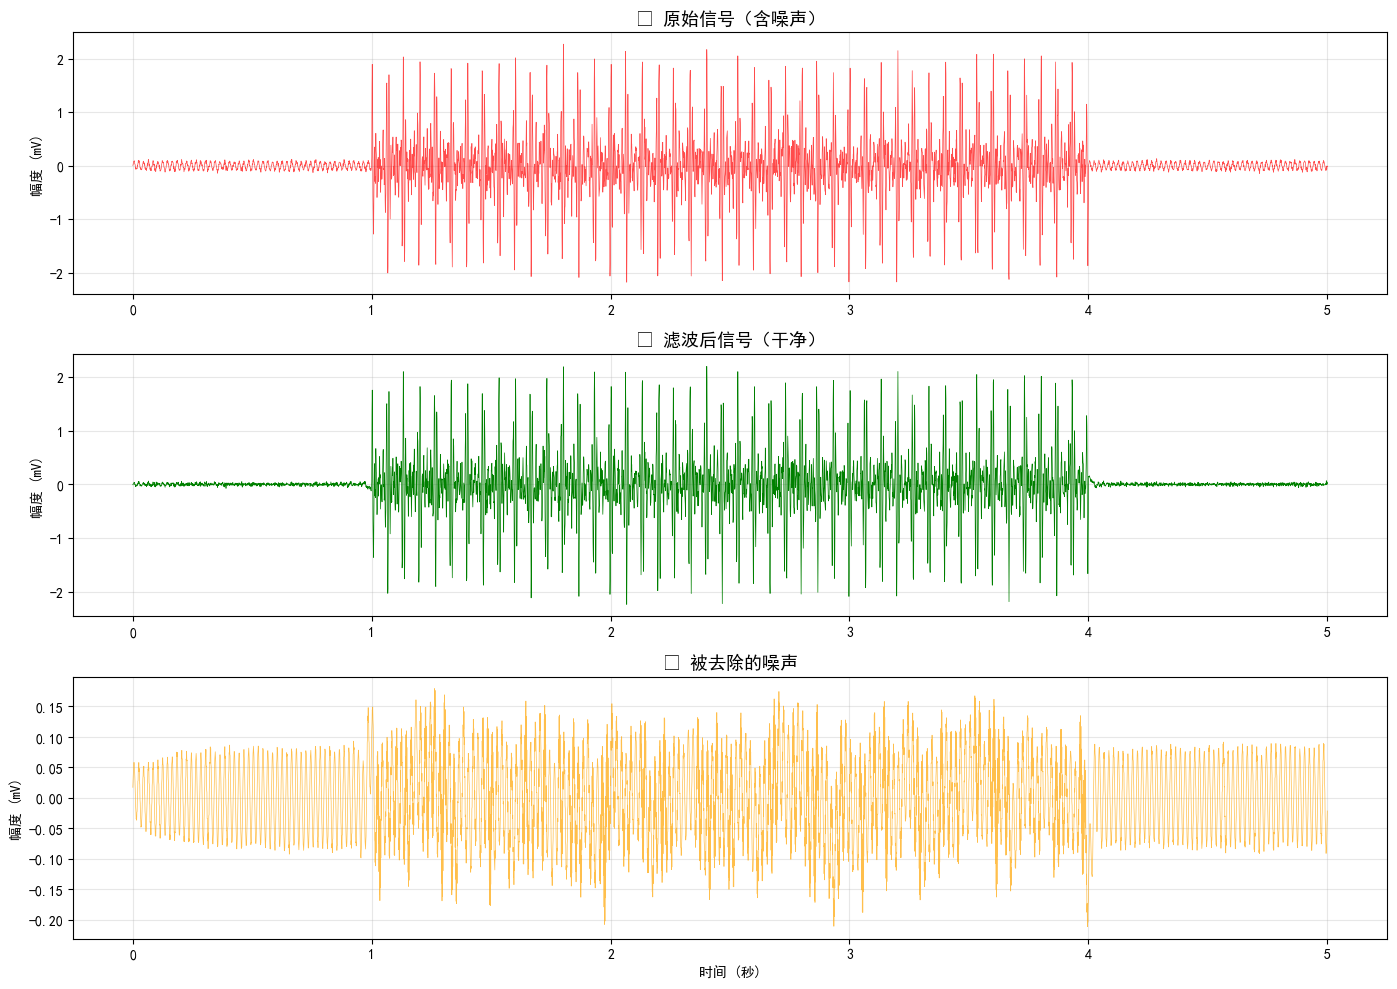


噪声去除效果：
  原始信号标准差: 0.5092 mV
  滤波后标准差: 0.5038 mV
  噪声改善比: 1.01x


In [5]:
# ===== 应用滤波器进行信号去噪 =====

# --- 第一步：创建滤波器对象 ---
filters = EMGFilters(fs=fs)  # 传入采样率，初始化滤波器

# --- 第二步：完整预处理（带通滤波 + 陷波滤波） ---
signal_clean = filters.preprocess_emg(
    signal_noisy,           # 输入：带噪声的原始信号
    remove_powerline=True,  # 启用陷波滤波，去除工频干扰
    powerline_freq=50       # 指定工频频率为50Hz（中国/欧洲标准，美国是60Hz）
)
# preprocess_emg内部会自动执行：
#   1. 带通滤波（20-500 Hz）- 保留EMG有效频率范围
#   2. 陷波滤波（50 Hz）- 去除工频干扰
#   3. 归一化处理 - 统一信号幅度范围

# --- 第三步：可视化对比（三层图） ---
fig, axes = plt.subplots(3, 1, figsize=(14, 10))  # 创建3个子图，垂直排列

# 【子图1】原始信号（含噪声）
axes[0].plot(t, signal_noisy, linewidth=0.5, color='red', alpha=0.7)
axes[0].set_title('① 原始信号（含噪声）', fontsize=13, fontweight='bold')
axes[0].set_ylabel('幅度 (mV)')
axes[0].grid(True, alpha=0.3)  # 添加网格线，透明度30%

# 【子图2】滤波后信号（干净）
axes[1].plot(t, signal_clean, linewidth=0.5, color='green')
axes[1].set_title('② 滤波后信号（干净）', fontsize=13, fontweight='bold')
axes[1].set_ylabel('幅度 (mV)')
axes[1].grid(True, alpha=0.3)

# 【子图3】被去除的噪声（对比看去掉了什么）
noise = signal_noisy - signal_clean  # 计算差值：原始 - 干净 = 噪声
axes[2].plot(t, noise, linewidth=0.5, color='orange', alpha=0.7)
axes[2].set_title('③ 被去除的噪声', fontsize=13, fontweight='bold')
axes[2].set_xlabel('时间 (秒)')
axes[2].set_ylabel('幅度 (mV)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()  # 自动调整子图间距，避免重叠
plt.show()

# --- 第四步：定量评估去噪效果 ---
print(f"\n噪声去除效果：")
print(f"  原始信号标准差: {np.std(signal_noisy):.4f} mV")
print(f"  滤波后标准差: {np.std(signal_clean):.4f} mV")
print(f"  噪声改善比: {np.std(signal_noisy)/np.std(signal_clean):.2f}x")
# 标准差越小说明信号越稳定、噪声越少

---
## 第二部分：特征提取

### 什么是特征提取？
- 从原始信号中提取**有意义的数值**
- 这些数值能够**区分不同的动作或状态**
- 用于后续的**分类和识别**

### 18种经典特征

**时域特征**（直接从波形计算）：
- **MAV**: 平均绝对值 → 反映肌肉激活强度
- **RMS**: 均方根 → 常用的幅度指标
- **VAR**: 方差 → 反映信号波动
- **WL**: 波形长度 → 反映信号复杂度
- **ZC**: 过零率 → 反映频率特性
- **SSC**: 斜率符号变化 → 反映频率
- **IEMG**: 积分EMG
- **DASDV**: 差分绝对标准差
- **PEAK**: 峰值
- **MEAN**: 均值

**频域特征**（通过傅里叶变换计算）：
- **MNF**: 平均频率
- **MDF**: 中值频率
- **Peak_Freq**: 峰值频率
- **Total_Power**: 总功率
- **SM1-3**: 频谱矩
- **Freq_Ratio**: 频率比

In [6]:
# ===== 从干净的信号中提取特征 =====

# --- 第一步：提取时域特征（10种） ---
# 时域特征直接从信号波形计算，不需要傅里叶变换
time_features = EMGFeatures.extract_time_features(signal_clean)
# 返回一个字典，包含：MAV, RMS, VAR, WL, ZC, SSC, IEMG, DASDV, PEAK, MEAN

# --- 第二步：提取频域特征（8种） ---
# 频域特征通过傅里叶变换得到，反映信号的频率分布
freq_features = EMGFeatures.extract_freq_features(signal_clean, fs=fs)
# 返回一个字典，包含：MNF, MDF, Peak_Freq, Total_Power, SM1, SM2, SM3, Freq_Ratio
# 需要传入采样率fs，因为频域分析需要知道时间刻度

# --- 第三步：打印所有特征 ---
print("时域特征（10种）：")
print("-" * 40)
for name, value in time_features.items():
    print(f"{name:10s}: {value:10.6f}")
    # name:10s 表示名称占10个字符宽度，左对齐
    # value:10.6f 表示数值占10个字符，保留6位小数

print("\n频域特征（8种）：")
print("-" * 40)
for name, value in freq_features.items():
    print(f"{name:15s}: {value:10.6f}")

# --- 特征含义快速参考 ---
print("\n💡 关键特征含义：")
print("  MAV/RMS → 信号强度（肌肉收缩力度）")
print("  WL → 信号复杂度（波形变化程度）")
print("  ZC/SSC → 信号频率（通过时域方法估计）")
print("  MNF/MDF → 平均/中值频率（频域精确测量）")
print("  Total_Power → 信号总能量")

时域特征（10种）：
----------------------------------------
MAV       :   0.275355
RMS       :   0.503778
VAR       :   0.253793
WL        : 1031.440367
ZC        : 1092.000000
SSC       : 902.000000
IEMG      : 1376.775562
DASDV     :   0.347446
PEAK      :   2.234208
MEAN      :   0.000030

频域特征（8种）：
----------------------------------------
MNF            : 107.293837
MDF            : 100.000000
Peak_Freq      : 115.000000
Total_Power    :   0.507585
SM1            : 107.293837
SM2            : 13788.835258
SM3            : 2427706.363809
Freq_Ratio     :   1.332777

💡 关键特征含义：
  MAV/RMS → 信号强度（肌肉收缩力度）
  WL → 信号复杂度（波形变化程度）
  ZC/SSC → 信号频率（通过时域方法估计）
  MNF/MDF → 平均/中值频率（频域精确测量）
  Total_Power → 信号总能量


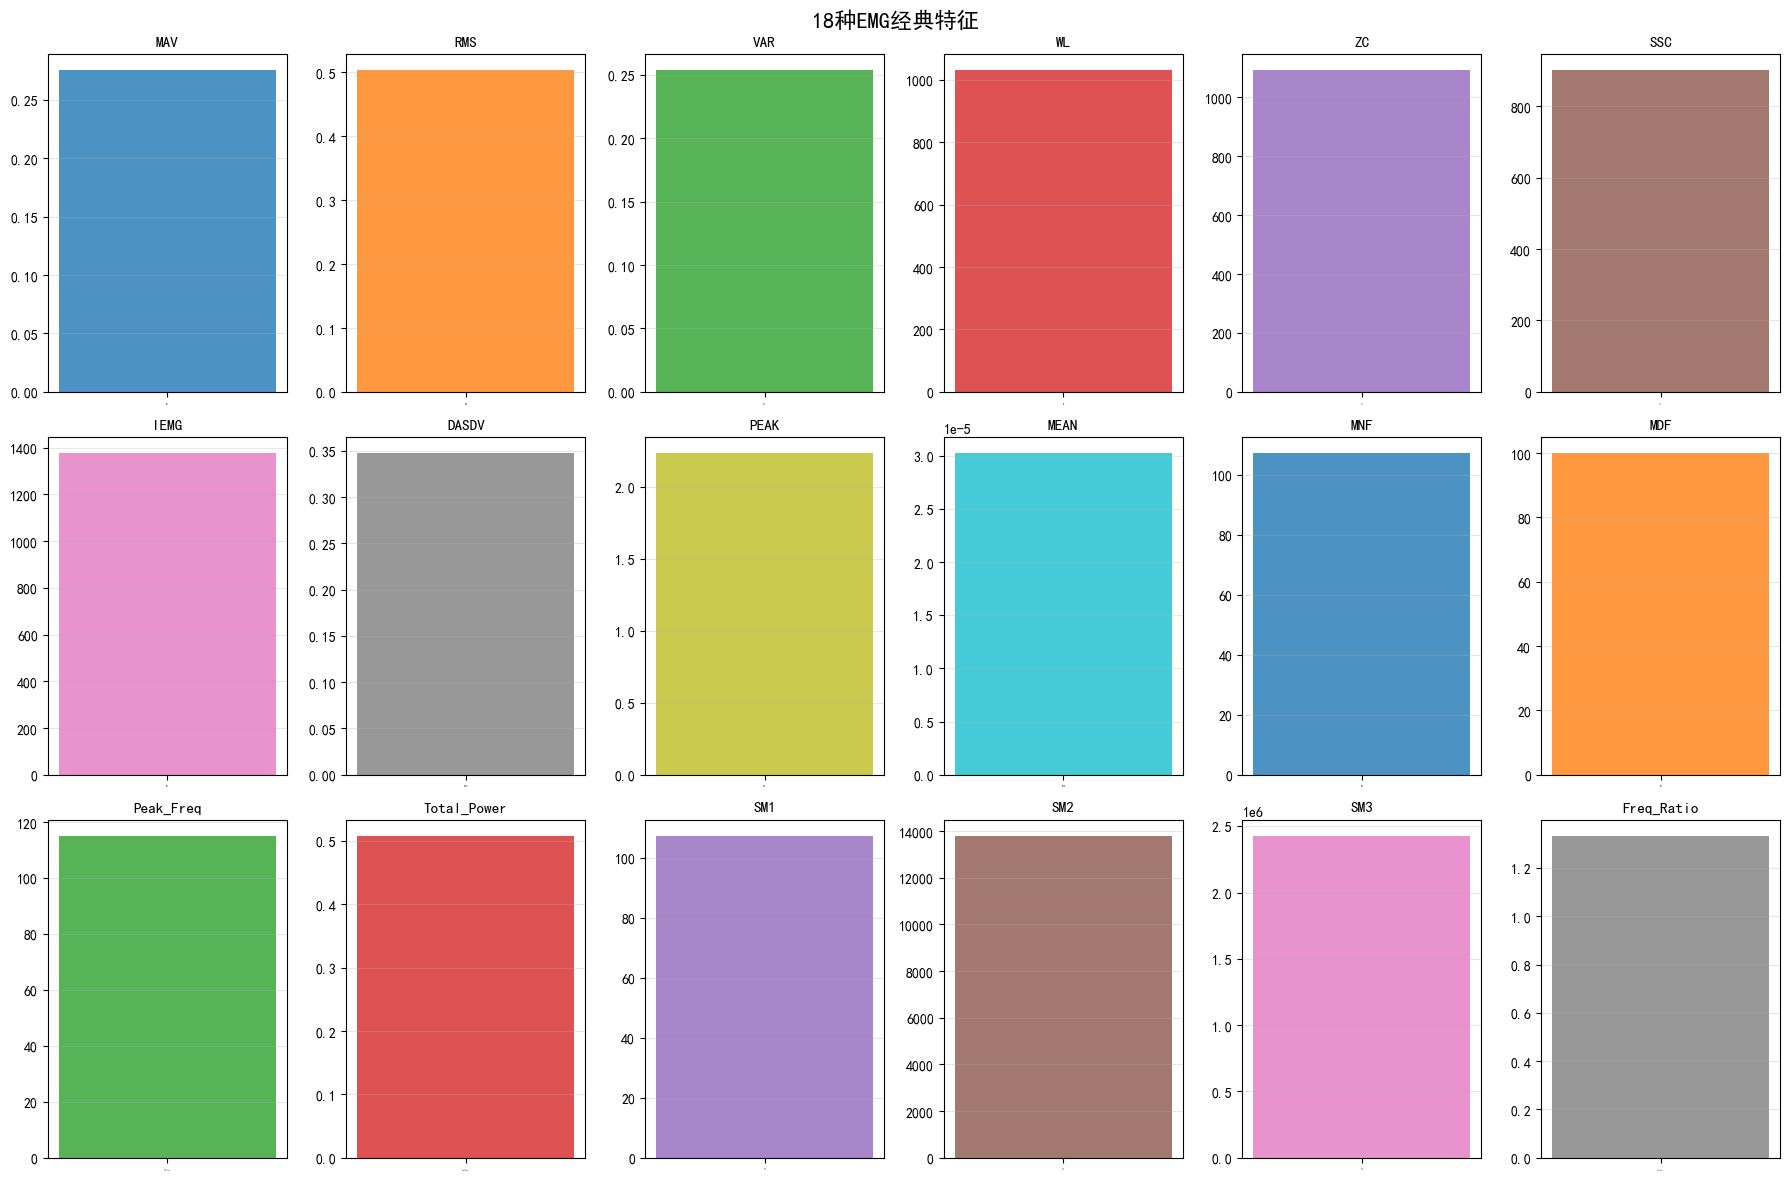


✓ 共提取 18 种特征
  时域特征: 10 种
  频域特征: 8 种


In [7]:
# ===== 可视化所有18种特征 =====

# --- 第一步：合并时域和频域特征 ---
all_features = {**time_features, **freq_features}
# 使用字典解包（**）合并两个字典，得到包含全部18个特征的字典

# --- 第二步：创建图表布局（3行×6列 = 18个子图） ---
fig, axes = plt.subplots(3, 6, figsize=(18, 12))
# 3行6列的网格布局，每个特征占一个位置
fig.suptitle('18种EMG经典特征', fontsize=16, fontweight='bold')

# --- 第三步：遍历每个特征，绘制柱状图 ---
for idx, (name, value) in enumerate(all_features.items()):
    # idx: 0到17，表示第几个特征
    # name: 特征名称（如'MAV'）
    # value: 特征值（数值）
    
    # 计算该特征应该放在哪一行、哪一列
    row = idx // 6  # 整除：0-5在第0行，6-11在第1行，12-17在第2行
    col = idx % 6   # 取余：列号0-5循环
    
    # 在对应位置画柱状图
    axes[row, col].bar(
        [name],              # x轴：特征名称
        [value],             # y轴：特征值
        color=f'C{idx % 10}',  # 颜色：使用matplotlib默认调色板，循环使用
        alpha=0.8            # 透明度：80%不透明
    )
    
    # 设置子图标题和样式
    axes[row, col].set_title(name, fontsize=11, fontweight='bold')
    axes[row, col].tick_params(axis='x', labelsize=0)  # 隐藏x轴标签（避免重复显示特征名）
    axes[row, col].grid(True, alpha=0.3, axis='y')  # 只在y轴显示网格线

plt.tight_layout()  # 自动调整间距
plt.show()

# --- 第四步：打印统计信息 ---
print(f"\n✓ 共提取 {len(all_features)} 种特征")
print(f"  时域特征: {len(time_features)} 种")
print(f"  频域特征: {len(freq_features)} 种")

---
## 第三部分：不同群体的差异分析

### 研究问题
- 正常人的EMG信号有什么特点？
- 运动功能障碍患者的信号有何不同？
- 哪些特征最能区分不同群体？

### 三个群体
1. **正常人**: 肌肉收缩强有力，频率正常
2. **轻度障碍**: 收缩较弱，频率略低
3. **重度障碍**: 收缩很弱，频率明显降低

In [8]:
# ===== 生成三组不同患者的模拟数据 =====

def generate_patient_data(patient_type, n_samples=20):
    """
    生成指定类型患者的EMG数据
    
    参数:
        patient_type: 患者类型 ('normal', 'mild', 'severe')
        n_samples: 生成样本数量
    
    返回:
        samples: 特征字典列表，每个字典包含18个特征
    """
    # --- 初始化 ---
    fs = 1000  # 采样率
    duration = 5  # 信号时长
    filters = EMGFilters(fs=fs)  # 创建滤波器
    samples = []  # 存储所有样本
    
    # --- 循环生成n_samples个样本 ---
    for _ in range(n_samples):
        # 1. 生成时间轴
        t = np.linspace(0, duration, int(duration * fs))
        
        # 2. 生成基础噪声
        signal = np.random.normal(0, 0.02, len(t))
        
        # 3. 设定收缩期范围（1-4秒）
        start = int(1 * fs)
        end = int(4 * fs)
        
        # 4. 根据患者类型生成不同的EMG信号
        if patient_type == 'normal':
            # 【正常人】强收缩，高频率（70-140 Hz）
            for freq in range(70, 140, 15):  # 频率：70, 85, 100, 115, 130 Hz
                signal[start:end] += 0.4 * np.sin(2 * np.pi * freq * t[start:end])
                # 振幅0.4 mV - 强有力的肌肉收缩
            signal[start:end] += np.random.normal(0, 0.15, end - start)
            
        elif patient_type == 'mild':
            # 【轻度障碍】中等收缩，较低频率（60-120 Hz）
            for freq in range(60, 120, 15):  # 频率：60, 75, 90, 105 Hz
                signal[start:end] += 0.25 * np.sin(2 * np.pi * freq * t[start:end])
                # 振幅0.25 mV - 收缩力度减弱
            signal[start:end] += np.random.normal(0, 0.12, end - start)
            
        elif patient_type == 'severe':
            # 【重度障碍】弱收缩，低频率（50-100 Hz）
            for freq in range(50, 100, 20):  # 频率：50, 70, 90 Hz（频率成分更少）
                signal[start:end] += 0.15 * np.sin(2 * np.pi * freq * t[start:end])
                # 振幅0.15 mV - 收缩力度很弱
            signal[start:end] += np.random.normal(0, 0.1, end - start)
        
        # 5. 预处理信号（去噪）
        signal_clean = filters.preprocess_emg(signal, remove_powerline=True)
        
        # 6. 提取特征
        time_feat = EMGFeatures.extract_time_features(signal_clean)  # 时域特征
        freq_feat = EMGFeatures.extract_freq_features(signal_clean, fs=fs)  # 频域特征
        
        # 7. 合并特征并添加到样本列表
        sample = {**time_feat, **freq_feat}
        samples.append(sample)
    
    return samples

# ===== 生成所有数据 =====
print("开始生成三组数据...")

# 生成每组数据（每组20个样本）
data_normal = generate_patient_data('normal', n_samples=20)    # 正常人
data_mild = generate_patient_data('mild', n_samples=20)        # 轻度障碍
data_severe = generate_patient_data('severe', n_samples=20)    # 重度障碍

# 为每个样本添加组别标签
for sample in data_normal:
    sample['group'] = '正常人'
for sample in data_mild:
    sample['group'] = '轻度障碍'
for sample in data_severe:
    sample['group'] = '重度障碍'

# 合并所有数据到一个列表
all_data = data_normal + data_mild + data_severe

# 转换为pandas DataFrame（表格格式，方便分析）
df = pd.DataFrame(all_data)

# 打印数据集信息
print(f"✓ 数据生成完成：{len(df)}个样本")
print(f"  正常人: {len(data_normal)}个")
print(f"  轻度障碍: {len(data_mild)}个")
print(f"  重度障碍: {len(data_severe)}个")
print(f"\n数据表格形状: {df.shape}")
print(f"  行数（样本数）: {df.shape[0]}")
print(f"  列数（特征数+标签）: {df.shape[1]}")

开始生成三组数据...
✓ 数据生成完成：60个样本
  正常人: 20个
  轻度障碍: 20个
  重度障碍: 20个

数据表格形状: (60, 19)
  行数（样本数）: 60
  列数（特征数+标签）: 19


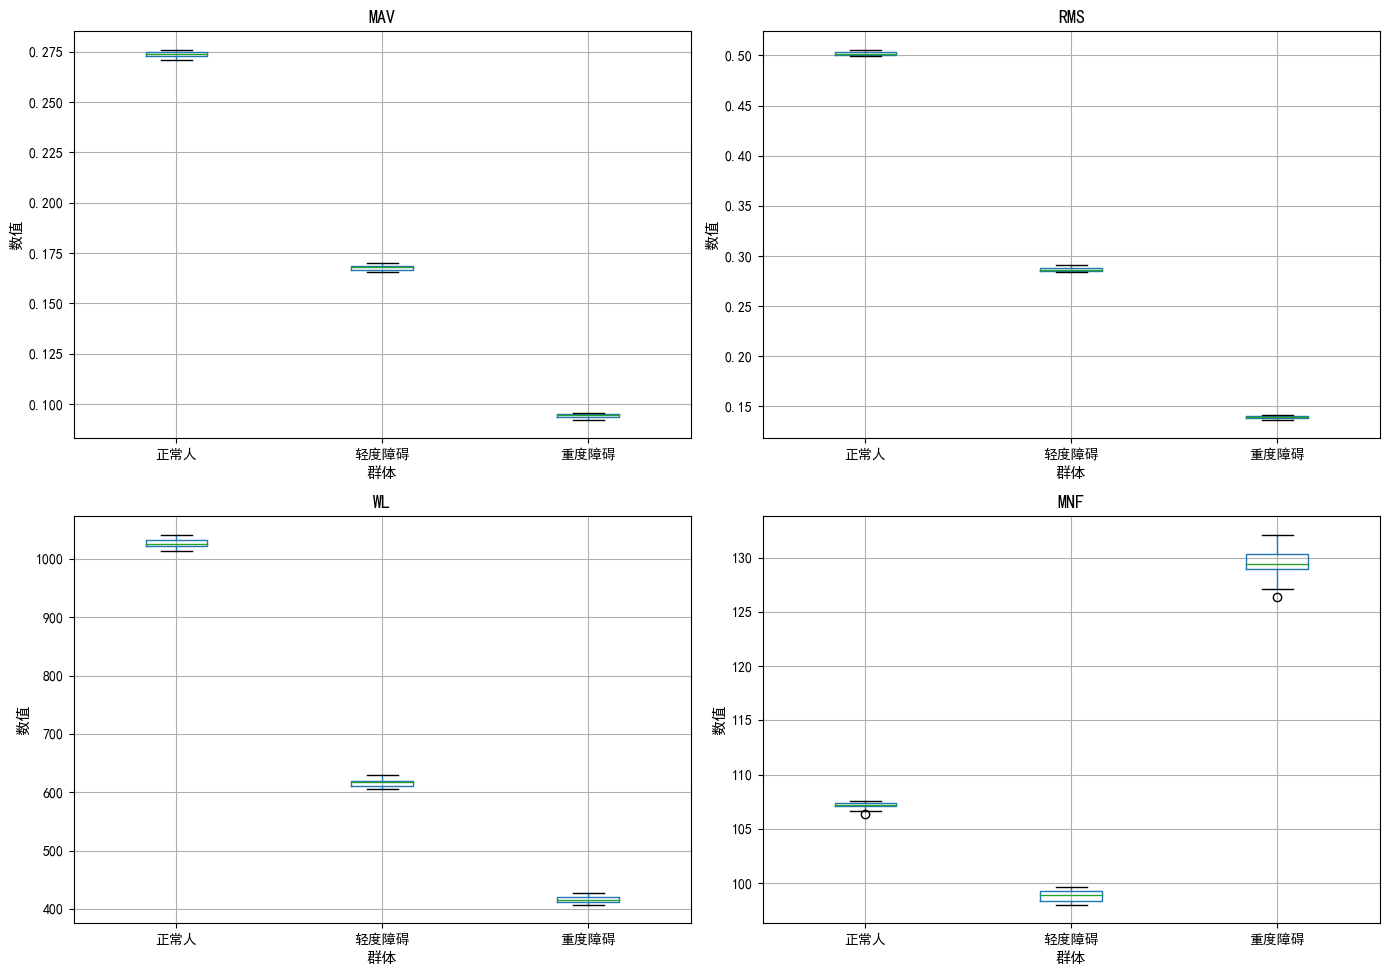


📊 观察要点：
  箱线图说明：
    - 箱子：中间50%的数据分布范围（第25-75百分位）
    - 箱子中的线：中位数（第50百分位）
    - 须（whiskers）：数据的延伸范围
    - 圆点：离群值（异常值）

  预期观察结果：
    - MAV/RMS: 正常人 > 轻度障碍 > 重度障碍（信号强度递减）
    - WL: 正常人最高（信号最复杂）
    - MNF: 正常人频率最高（肌肉激活更快）


In [9]:
# ===== 可视化不同群体的关键特征对比 =====

# --- 选择4个最具代表性的特征 ---
key_features = ['MAV', 'RMS', 'WL', 'MNF']
# MAV: 平均绝对值（强度）
# RMS: 均方根（强度，更稳定）
# WL: 波形长度（复杂度）
# MNF: 平均频率（频率特性）

# --- 创建2×2子图布局 ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('不同群体的关键特征对比', fontsize=16, fontweight='bold')

# --- 遍历每个特征，绘制箱线图 ---
for idx, feat in enumerate(key_features):
    # 计算子图位置
    row = idx // 2  # 行号：0或1
    col = idx % 2   # 列号：0或1
    
    # 使用pandas的boxplot功能绘制分组箱线图
    df.boxplot(
        column=feat,        # 要对比的特征列
        by='group',         # 按'group'列分组
        ax=axes[row, col]   # 在指定的子图上绘制
    )
    
    # 设置子图标题和标签
    axes[row, col].set_title(feat, fontsize=13, fontweight='bold')
    axes[row, col].set_xlabel('群体', fontsize=11)
    axes[row, col].set_ylabel('数值', fontsize=11)
    axes[row, col].get_figure().suptitle('')  # 移除pandas自动添加的总标题

plt.tight_layout()
plt.show()

# --- 打印观察要点 ---
print("\n📊 观察要点：")
print("  箱线图说明：")
print("    - 箱子：中间50%的数据分布范围（第25-75百分位）")
print("    - 箱子中的线：中位数（第50百分位）")
print("    - 须（whiskers）：数据的延伸范围")
print("    - 圆点：离群值（异常值）")
print()
print("  预期观察结果：")
print("    - MAV/RMS: 正常人 > 轻度障碍 > 重度障碍（信号强度递减）")
print("    - WL: 正常人最高（信号最复杂）")
print("    - MNF: 正常人频率最高（肌肉激活更快）")

In [10]:
# ===== 统计检验：ANOVA方差分析 =====

# ANOVA (Analysis of Variance) 用于检验三个或多个组之间的均值差异是否显著

print("统计检验（ANOVA）：")
print("=" * 60)

# --- 对每个关键特征进行ANOVA检验 ---
for feat in key_features:
    # 1. 提取三组数据
    normal_data = df[df['group'] == '正常人'][feat]      # 正常组的该特征数据
    mild_data = df[df['group'] == '轻度障碍'][feat]      # 轻度障碍组
    severe_data = df[df['group'] == '重度障碍'][feat]    # 重度障碍组
    
    # 2. 执行单因素方差分析
    f_stat, p_value = stats.f_oneway(normal_data, mild_data, severe_data)
    # f_stat: F统计量，值越大说明组间差异越大
    # p_value: p值，< 0.05表示差异显著
    
    # 3. 根据p值判断显著性水平
    if p_value < 0.001:
        sig = "***"  # 非常显著
    elif p_value < 0.01:
        sig = "**"   # 显著
    elif p_value < 0.05:
        sig = "*"    # 较显著
    else:
        sig = "ns"   # 不显著 (not significant)
    
    # 4. 打印结果
    print(f"{feat:10s}: F={f_stat:8.3f}, p={p_value:.6f} {sig}")
    # F值：组间方差/组内方差的比值
    # p值：小于0.05表示差异有统计学意义

print("\n" + "=" * 60)
print("显著性标记说明：")
print("  *** → p < 0.001 (非常显著，差异很明显)")
print("  **  → p < 0.01  (显著，差异明显)")
print("  *   → p < 0.05  (较显著，差异存在)")
print("  ns  → p ≥ 0.05  (不显著，差异可能是偶然的)")
print("\n💡 解读：")
print("  如果p < 0.05，说明三组之间的差异不是由随机误差造成的，")
print("  而是真实存在的，具有统计学意义。")

统计检验（ANOVA）：
MAV       : F=111319.586, p=0.000000 ***
RMS       : F=211318.161, p=0.000000 ***
WL        : F=47295.871, p=0.000000 ***
MNF       : F=5468.740, p=0.000000 ***

显著性标记说明：
  *** → p < 0.001 (非常显著，差异很明显)
  **  → p < 0.01  (显著，差异明显)
  *   → p < 0.05  (较显著，差异存在)
  ns  → p ≥ 0.05  (不显著，差异可能是偶然的)

💡 解读：
  如果p < 0.05，说明三组之间的差异不是由随机误差造成的，
  而是真实存在的，具有统计学意义。


---
## 第四部分：分类器对比

### 任务目标
根据EMG特征，自动判断一个人属于哪个群体

### 三种经典分类器

1. **SVM (Support Vector Machine)**
   - 支持向量机
   - 寻找最优分类边界
   - 适合中小规模数据

2. **KNN (K-Nearest Neighbors)**
   - K近邻算法
   - 根据最近的k个样本投票
   - 简单直观

3. **Random Forest**
   - 随机森林
   - 多个决策树投票
   - 性能稳定，抗过拟合

In [11]:
# ===== 准备机器学习数据 =====

# --- 第一步：分离特征和标签 ---
# 获取所有特征列（除了'group'列）
feature_cols = [col for col in df.columns if col != 'group']
# 这是一个列表推导式，筛选出所有不是'group'的列名

# 提取特征矩阵X（所有样本的所有特征）
X = df[feature_cols].values
# shape: (60, 18) - 60个样本，每个样本18个特征

# 提取标签向量y（所有样本的组别）
y = df['group'].values
# shape: (60,) - 60个文本标签

# --- 第二步：标签编码（文本 → 数字） ---
# 机器学习算法只能处理数字，需要将文本标签转换为数字
label_map = {
    '正常人': 0,
    '轻度障碍': 1,
    '重度障碍': 2
}

# 使用列表推导式进行批量转换
y_numeric = np.array([label_map[label] for label in y])
# '正常人' → 0, '轻度障碍' → 1, '重度障碍' → 2

# --- 第三步：打印数据信息 ---
print("✓ 数据准备完成")
print(f"\n特征矩阵 X: {X.shape}")
print(f"  - 样本数: {X.shape[0]}")
print(f"  - 特征数: {X.shape[1]}")
print(f"\n标签向量 y: {y_numeric.shape}")
print(f"  - 类别数: {len(label_map)}")
print(f"\n标签分布:")
for label_name, label_code in label_map.items():
    count = np.sum(y_numeric == label_code)
    print(f"  {label_name} (编码{label_code}): {count}个样本")

✓ 数据准备完成

特征矩阵 X: (60, 18)
  - 样本数: 60
  - 特征数: 18

标签向量 y: (60,)
  - 类别数: 3

标签分布:
  正常人 (编码0): 20个样本
  轻度障碍 (编码1): 20个样本
  重度障碍 (编码2): 20个样本


In [12]:
# ===== 训练三种不同的分类器 =====

# --- 第一步：定义要训练的分类器及其参数 ---
classifiers = [
    # (分类器类型, 参数字典, 显示名称)
    ('random_forest', {'n_estimators': 100}, 'Random Forest'),
    # Random Forest: 随机森林，使用100棵决策树投票
    
    ('svm', {'kernel': 'rbf', 'C': 1.0}, 'SVM'),
    # SVM: 支持向量机，使用径向基核函数(RBF)，正则化参数C=1.0
    
    ('knn', {'n_neighbors': 5}, 'KNN')
    # KNN: K近邻，考虑最近的5个邻居进行投票
]

# 用于存储所有分类器的结果
results = []

# --- 第二步：训练每个分类器 ---
for clf_type, params, name in classifiers:
    print(f"\n{'='*60}")
    print(f"正在训练 {name}...")
    print(f"{'='*60}")
    
    # 1. 创建分类器对象
    clf = EMGClassifier(classifier_type=clf_type, **params)
    # **params 将字典解包为关键字参数
    
    # 2. 划分训练集和测试集
    X_train, X_test, y_train, y_test = clf.prepare_data(
        X, y_numeric,
        test_size=0.3,      # 30%的数据用于测试
        random_state=42     # 固定随机种子，保证结果可重复
    )
    # 训练集: 70% × 60 = 42个样本
    # 测试集: 30% × 60 = 18个样本
    
    print(f"  训练集: {len(X_train)}个样本")
    print(f"  测试集: {len(X_test)}个样本")
    
    # 3. 训练模型
    clf.train(
        X_train, y_train,
        feature_names=feature_cols,          # 特征名称列表
        gesture_names=list(label_map.keys()) # 手势名称列表
    )
    print(f"  ✓ 训练完成")
    
    # 4. 在测试集上评估
    accuracy = clf.evaluate(X_test, y_test)
    print(f"  📊 测试集准确率: {accuracy:.2%}")
    
    # 5. 保存结果
    results.append({
        'classifier': name,
        'accuracy': accuracy * 100  # 转换为百分比
    })

# --- 第三步：汇总结果 ---
results_df = pd.DataFrame(results)
print(f"\n{'='*60}")
print("✓ 所有分类器训练完成")
print(f"{'='*60}")


正在训练 Random Forest...
训练集大小: (42, 18)
测试集大小: (18, 18)
训练集标签分布: [14 14 14]
测试集标签分布: [6 6 6]
  训练集: 42个样本
  测试集: 18个样本

训练 random_forest 分类器...
训练完成！训练集准确率: 100.00%
  ✓ 训练完成

测试集准确率: 100.00%

分类报告:
              precision    recall  f1-score   support

         正常人       1.00      1.00      1.00         6
        轻度障碍       1.00      1.00      1.00         6
        重度障碍       1.00      1.00      1.00         6

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18

  📊 测试集准确率: 100.00%

正在训练 SVM...
训练集大小: (42, 18)
测试集大小: (18, 18)
训练集标签分布: [14 14 14]
测试集标签分布: [6 6 6]
  训练集: 42个样本
  测试集: 18个样本

训练 svm 分类器...
训练完成！训练集准确率: 100.00%
  ✓ 训练完成

测试集准确率: 100.00%

分类报告:
              precision    recall  f1-score   support

         正常人       1.00      1.00      1.00         6
        轻度障碍       1.00      1.00      1.00         6
        重度障碍       1.00      1.00      1.00         6

    acc

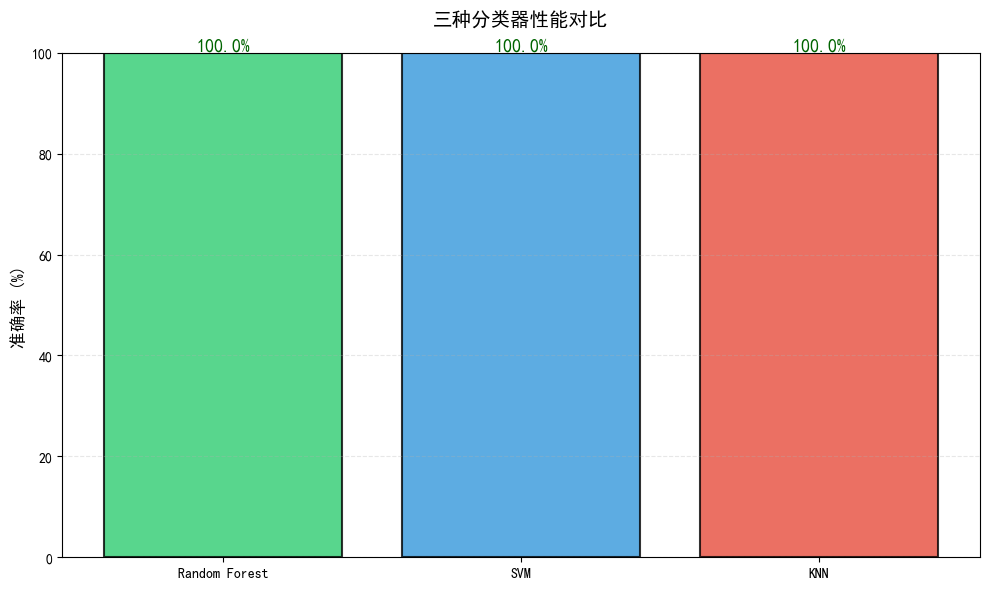


🏆 分类器排名（按准确率从高到低）：
🥇 第1名: Random Forest   - 100.00%
🥈 第2名: SVM             - 100.00%
🥉 第3名: KNN             - 100.00%

📈 性能分析：
  最佳分类器: Random Forest
  最高准确率: 100.00%

  如果准确率 > 90%: 非常优秀，模型性能很好
  如果准确率 80-90%: 良好，可以实际应用
  如果准确率 70-80%: 一般，需要改进
  如果准确率 < 70%: 较差，需要重新设计


In [13]:
# ===== 可视化分类器性能对比 =====

# --- 第一步：创建柱状图 ---
fig, ax = plt.subplots(figsize=(10, 6))

# 定义颜色方案（绿、蓝、红）
colors = ['#2ecc71', '#3498db', '#e74c3c']

# 绘制柱状图
bars = ax.bar(
    results_df['classifier'],  # x轴：分类器名称
    results_df['accuracy'],    # y轴：准确率（%）
    color=colors,              # 每个柱子的颜色
    alpha=0.8,                 # 透明度80%
    edgecolor='black',         # 柱子边框颜色
    linewidth=1.5              # 边框宽度
)

# --- 第二步：设置图表样式 ---
ax.set_ylabel('准确率 (%)', fontsize=12, fontweight='bold')
ax.set_title('三种分类器性能对比', fontsize=14, fontweight='bold', pad=20)
ax.set_ylim(0, 100)  # y轴范围：0-100%
ax.grid(True, alpha=0.3, axis='y', linestyle='--')  # 添加水平网格线

# --- 第三步：在柱子顶部标注准确率数值 ---
for bar in bars:
    height = bar.get_height()  # 获取柱子高度（即准确率）
    ax.text(
        bar.get_x() + bar.get_width()/2.,  # x坐标：柱子中心
        height,                             # y坐标：柱子顶部
        f'{height:.1f}%',                   # 显示文本：保留1位小数
        ha='center',                        # 水平居中
        va='bottom',                        # 垂直对齐底部（显示在柱子上方）
        fontsize=13,
        fontweight='bold',
        color='darkgreen'
    )

plt.tight_layout()
plt.show()

# --- 第四步：打印排名 ---
print("\n🏆 分类器排名（按准确率从高到低）：")
print("=" * 50)

# 按准确率降序排列
results_sorted = results_df.sort_values('accuracy', ascending=False)

for rank, (idx, row) in enumerate(results_sorted.iterrows(), 1):
    # rank: 排名（1, 2, 3）
    # row: 该行数据
    medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉"
    print(f"{medal} 第{rank}名: {row['classifier']:15s} - {row['accuracy']:.2f}%")

print("=" * 50)

# --- 第五步：性能分析 ---
print("\n📈 性能分析：")
best_clf = results_sorted.iloc[0]['classifier']
best_acc = results_sorted.iloc[0]['accuracy']
print(f"  最佳分类器: {best_clf}")
print(f"  最高准确率: {best_acc:.2f}%")
print(f"\n  如果准确率 > 90%: 非常优秀，模型性能很好")
print(f"  如果准确率 80-90%: 良好，可以实际应用")
print(f"  如果准确率 70-80%: 一般，需要改进")
print(f"  如果准确率 < 70%: 较差，需要重新设计")

---
## 总结

### 完整流程回顾

```
原始EMG信号
    ↓
消噪/滤波（带通 + 陷波）
    ↓
特征提取（18种）
    ↓
统计分析（ANOVA）
    ↓
分类器训练（SVM/KNN/RF）
    ↓
自动识别
```

### 关键发现
1. **消噪很重要**：能显著提高信号质量
2. **特征有差异**：正常人和障碍患者的特征显著不同
3. **分类可行**：机器学习能够自动区分不同群体

### 实际应用
- 康复评估：量化评估患者恢复情况
- 辅助诊断：帮助医生判断功能障碍程度
- 假肢控制：根据EMG控制机械手
- 运动分析：评估运动员肌肉状态